### Orchestrator-Worker
- Generate a detail Report

In [37]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

### Langsmith tracking
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = os.getenv("LANGCHAIN_PROJECT")

In [38]:
### initialize the llm model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [39]:
import operator
from typing import Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

In [40]:
class Section(BaseModel):
    name:str = Field(description="Name for this section of the Report")
    description:str = Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section] = Field(description="Sections of the report")

## Augement the LLM with Schema forStructure output
planner = llm.with_structured_output(Sections)

### Creating Workers Dynamically in langgraph

In [41]:
## Graph State
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [42]:
## defining the Orchestrator Worker Node
def orchestator(state:State):
    """Orchestator that generates a plan for the report"""

    # Generate Query
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state["topic"]}")
        ]
    )

    print("Report Sections : ", report_sections)

    return {"sections":report_sections.sections}

In [43]:
## llm call for each worker node
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    ## Generate sections
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting"),
            HumanMessage(content=f"Here is the section name: {state["section"].name} and description: {state["section"].description}")
        ]
    )

    ## Write the updated section to completed sections
    return {"completed_sections":[section.content]}

In [44]:
from langgraph.constants import Send

# Conditional Edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    ## Kick off section writing parallel vis Send
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [45]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

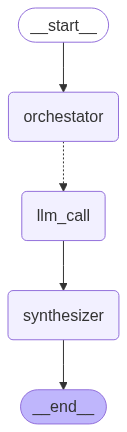

In [46]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Creating the graph
builder = StateGraph(State)

## Adding the Node
builder.add_node("orchestator", orchestator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

## Adding the Edges
builder.add_edge(START, "orchestator")
builder.add_conditional_edges(
    "orchestator", assign_workers, ["llm_call"]
)
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)


## Compile the Graph
graph_builder = builder.compile()

## View the Graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [47]:
# Invoke
from IPython.display import Markdown

state = {"topic":"Create a report on Agentic AI RAGs."}
result = graph_builder.invoke(state)

## Displaying Markdown text
Markdown(result["final_report"])

Report Sections :  sections=[Section(name='Introduction', description='Define Agentic AI RAGs, provide context, and explain the necessity of the report.'), Section(name='Background and Context', description='Explore the evolution of AI models with a focus on the Recurrent AI Agents with Goals (RAGs) framework. Discuss the historical development and the main motivations behind agentic AI.'), Section(name='Technical Overview of RAGs', description='Delve into the architecture and components of Agentic AI RAGs, explaining how they function, learning mechanisms, and goal-setting processes.'), Section(name='Applications and Use-Cases', description='Analyze current and potential applications of Agentic AI RAGs in various industries like healthcare, finance, and autonomous systems, showcasing their benefits and challenges.'), Section(name='Ethical Considerations and Challenges', description='Discuss the ethical implications of deploying Agentic AI RAGs, including issues around autonomy, decisi

## Introduction

In recent years, the rapid advancement of artificial intelligence has given rise to increasingly sophisticated systems capable of exhibiting a wide range of autonomous behaviors. Among these systems, Agentic AI with Retrieval-Augmented Generation (RAG) models have emerged as a particularly promising area of research and application. At their core, these systems are designed to harness the capabilities of large language models combined with the ability to access and retrieve external information, thereby enhancing their performance, accuracy, and utility across a variety of tasks.

Agentic AI RAGs represent a new paradigm in AI development, where agents are not just passive data processors but active participants in dynamic environments. These agents can autonomously seek out information to supplement their knowledge, make decisions based on a combination of learned data and real-time inputs, and generate contextually relevant responses or actions. This level of sophistication has significant implications for sectors such as customer service, content creation, healthcare, and more.

The necessity of this report arises from the growing complexity and potential impact of Agentic AI RAG systems on society and industry. As these systems become more integrated into everyday applications, understanding their functionalities, potentials, and limitations becomes crucial for stakeholders across various domains. This report aims to illuminate the underlying architectures of Agentic AI RAGs, outline their current applications, assess their capabilities, and discuss the challenges and ethical considerations inherent in their deployment.

By providing a comprehensive analysis of Agentic AI RAGs, this report seeks to empower decision-makers, developers, and users with the knowledge needed to responsibly harness these technologies, maximizing their benefits while mitigating any potential risks. As the field continues to evolve, informed insights will be key to guiding the responsible development and integration of AI technologies that align with societal values and goals.

---

## Background and Context

### Evolution of AI Models

Artificial Intelligence has undergone significant transformations over the past few decades, advancing from rule-based systems to sophisticated machine learning models capable of autonomous decision-making. These developments have been marked by an ever-increasing complexity and capability in AI technologies, paving the way for more specialized frameworks like Recurrent AI Agents with Goals (RAGs). 

Initially, AI systems were primarily deterministic, relying heavily on predefined rules and logical operations. As computing power and data availability grew, probabilistic models became prevalent, enabling machines to handle uncertainty and learn from data. This marked the transition into the era of machine learning, where algorithms such as neural networks began to take center stage.

The introduction of deep learning in the late 2000s, characterized by architectures like convolutional neural networks (CNNs) and recurrent neural networks (RNNs), revolutionized the field. These models could process complex data types like images and sequences, outperforming traditional AI methods in various tasks, notably in computer vision and natural language processing.

### Emergence of Agentic AI

The concept of agentic AI refers to systems capable of autonomous decision-making, responding to changing environments, and achieving specific objectives. The inspiration behind agentic AI has deep roots in the notion of building machines that can mimic certain aspects of human cognition and behavior, where the integration of learning, reasoning, and planning becomes paramount.

As AI models evolved, the need for more robust and autonomous systems became evident, especially in applications requiring continuous interaction with dynamic environments. This led to the development of frameworks emphasizing goal-directed behaviors, eventually giving rise to Recurrent AI Agents with Goals (RAGs). 

### Recurrent AI Agents with Goals (RAGs) Framework

The RAGs framework represents a significant step forward in achieving purposeful AI. It combines the strengths of recurrent neural networks, which excel at handling sequential data and maintaining state information, with a goal-oriented architecture. This melding allows RAGs to perform tasks over extended periods, adapt their strategies based on ongoing feedback, and realign their operations to achieve predefined objectives.

Historically, RAGs build upon the principles embedded in traditional agent-based models, which encapsulate the ideas of perception, decision-making, and actuation in a unified manner. The historical development of RAGs underscores the continuous evolution of AI towards more autonomous and adaptable systems that are not merely reactive but are proactive in pursuing their goals.

### Motivations Behind RAGs

The motivations for developing RAGs are multifaceted. A key driver is the need for AI systems that can operate effectively in real-world environments, where conditions are often unpredictable and changing. Another significant motivation is enhancing AI's ability to execute complex tasks without constant human intervention, thus increasing efficiency and enabling new applications in fields such as robotics, autonomous vehicles, and smart systems.

Moreover, the pursuit of agentic AI aligns with broader technological trends aimed at creating more intelligent, interactive systems that can collaborate with humans, anticipate needs, and assist in decision-making processes. The RAGs framework, with its emphasis on goal-oriented behavior, represents a vital component in realizing these ambitions, promising a future where AI systems become ever more integral to both personal and professional spheres.

---

### Technical Overview of RAGs

Agentic AI's Retrieval-Augmented Generation systems (RAGs) embody an advanced architecture tailored for dynamic information retrieval and generation tasks. The core design of RAGs merges retrieval-based systems with generative models, allowing the system to leverage large external knowledge bases in tandem with intricate natural language generation techniques. This hybrid approach not only enhances the accuracy of the outputs but also ensures that responses are rich with context-specific information.

#### Architecture and Components

The architecture of RAGs can be delineated into three primary components: the retriever, the generator, and the integrative module.

1. **Retriever:** The foremost task of the retriever is to scan and identify relevant documents or data entries from a vast corpus. This component typically employs sophisticated search algorithms and embedding techniques that transform the incoming query into a vector space. Advanced methods such as dense passage retrieval (DPR) are often employed to optimize accuracy and speed in the selection of pertinent information shards.

2. **Generator:** Once the retriever fetches relevant data, the generator synthesizes this information into coherent, natural language outputs. This component is usually underpinned by robust transformer models such as GPT or BERT, facilitating nuanced text generation that adheres to contextual and semantic constraints derived from the retrieved data. The generator is fine-tuned to handle a variety of linguistic complexities, ensuring responses are both relevant and articulate.

3. **Integrative Module:** This module acts as the bridge between retrieval and generation, ensuring smooth information flow and integration. It manages how retrieved data is contextually interwoven with generative processes. The integrative module plays a critical role in maintaining continuity and logic across multi-turn dialogs, weaving retrieved facts into meaningful and contextually appropriate narratives.

#### Learning Mechanisms

RAG systems utilize a combination of supervised learning and reinforcement learning to refine their performance. During training, supervised learning techniques are employed to teach the system optimal retrieval strategies and generative outputs using labeled datasets. Over time, reinforcement learning mechanisms enable the system to self-optimize, adjusting strategies based on feedback and interaction outcomes.

The learning process also involves continual feedback loops where RAGs assess the relevance of the retrieved information in alignment with generated outputs, aiding in refining retrieval strategies over time. This incorporation of continual learning ensures that RAGs remain adaptive to new data trends and user-specific nuances.

#### Goal-Setting Processes

In Agentic AI RAGs, goal-setting is an intrinsic process, dynamically modulated based on user inputs and pre-defined objectives. Each session begins with the system identifying the user's intent, often gleaned through semantic analysis and contextual cues. This intent determines the retrieval goals, aligning them with the broader objective of producing an accurate and contextually relevant response.

During interactions, RAGs may dynamically adjust goals in response to user feedback or changes in dialog context. This adaptability is vital for maintaining conversational relevance and cohesion, ensuring that the system not only meets immediate informational needs but also engages in a manner that's harmonious with the user's evolving inquiries.

In conclusion, the technical excellence of Agentic AI RAGs stems from their intricate architecture and sophisticated interplay between retrieval and generation components. By integrating advanced learning mechanisms and dynamic goal-setting processes, RAGs are equipped to deliver precise, context-rich, and coherent responses across diverse applications.

---

### Applications and Use-Cases

Agentic AI Retrieval-Augmented Generation (RAGs) presents a transformative opportunity across various industries, enhancing efficiency, decision-making, and problem-solving. Below, we delve into current and potential applications of RAGs in key sectors such as healthcare, finance, and autonomous systems, highlighting both their benefits and challenges.

#### Healthcare

**Current Applications:**

1. **Clinical Decision Support:** RAGs assist healthcare professionals by retrieving and generating insights from vast medical databases, leading to more accurate diagnoses and personalized treatment plans.
   
2. **Patient Interaction:** Chatbots powered by RAGs engage with patients, answering queries, scheduling appointments, and providing reminders, which enhances patient satisfaction and streamlines operations.

**Potential Applications:**

1. **Predictive Analysis:** By analyzing patient data, RAGs could predict health outcomes and the likelihood of diseases, aiding in preventive healthcare strategies.

2. **Medical Research Aggregation:** RAGs could automatically generate summaries of recent research from diverse sources, helping researchers stay updated with minimal effort.

**Benefits and Challenges:**

- **Benefits:** Improved precision in patient care, enhanced efficiency in data management, and reduced administrative burden on staff.
  
- **Challenges:** Ensuring data privacy, integrating RAG systems with existing healthcare IT infrastructures, and maintaining updated and accurate databases.

#### Finance

**Current Applications:**

1. **Fraud Detection:** RAGs enhance security by analyzing transaction patterns and generating alerts for potentially fraudulent activities in real-time.

2. **Investment Recommendations:** Wealth management firms employ RAGs to evaluate market trends and generate personalized investment strategies for clients.

**Potential Applications:**

1. **Regulatory Compliance:** RAGs could automate the retrieval and analysis of regulatory requirements, ensuring that financial institutions remain compliant with ever-changing laws.

2. **Market Simulation:** Artifically intelligent models can simulate market scenarios, which could help in stress-testing investment portfolios and better decision-making.

**Benefits and Challenges:**

- **Benefits:** Increased accuracy in financial decisions, improved customer service through personalized finance tools, and enhanced regulatory compliance.
  
- **Challenges:** Dependence on data quality, potential systemic biases in AI-generated insights, and the necessity for continuous training of the models to adapt to market changes.

#### Autonomous Systems

**Current Applications:**

1. **Navigational Accuracy:** RAGs contribute to autonomous vehicle systems by aggregating and interpreting data from maps and sensors to ensure precise navigation.

2. **Operational Efficiency:** In sectors like manufacturing, RAGs optimize logistics and assembly line operations by retrieving real-time data and generating actionable insights.

**Potential Applications:**

1. **Disaster Response:** RAGs could be used in drones or autonomous vehicles to dynamically retrieve data from affected areas and generate rapid response strategies during natural disasters.

2. **Space Exploration:** Autonomous spacecraft could rely on RAGs to make intelligent decisions based on incoming data from various instruments and sensors.

**Benefits and Challenges:**

- **Benefits:** Enhanced efficiency and safety in operations, reduced human intervention in hazardous environments, and streamlined data processing capabilities.
  
- **Challenges:** Technical limitations in real-time data processing, ensuring safety and ethical use of autonomous decision-making capabilities, and significant investment in R&D.

Overall, Agentic AI RAGs offer significant potential to revolutionize various sectors by enhancing data utility and decision-making processes. However, organizations must carefully consider the inherent challenges associated with implementation, including ethical considerations, data management, and system integration.

---

### Ethical Considerations and Challenges

The deployment of Agentic AI RAGs (Reinforcement-Action-Generative systems) brings forth a spectrum of ethical considerations, intertwined with the profound capabilities and autonomous nature of these technologies. Understanding these implications is pivotal as we navigate the integration of AI into domains requiring sophisticated decision-making and adaptivity.

#### Autonomy and Decision-Making

At the core of Agentic AI RAGs is their ability to make decisions autonomously. This autonomy, while a cornerstone of their utility, raises critical ethical questions about accountability and control. As these systems operate with a degree of independence, determining who is responsible for their actions becomes a complex issue. The delegation of decision-making power to AI could lead to scenarios where human oversight is either reduced or bypassed entirely, necessitating robust frameworks to govern these interactions.

Moreover, the extent to which these systems can understand and interpret the context within which they operate affects their ethical reliability. Ensuring that the decisions made by AI align with human values and societal norms is a significant challenge, one that demands rigorous design protocols and oversight mechanisms.

#### Potential Biases in Learning

Agentic AI RAGs learn from vast datasets, which inherently contain biases reflecting societal inequalities and historical prejudices. If unchecked, these biases can be perpetuated and even exacerbated by AI systems, leading to decisions that unfairly disadvantage certain groups or individuals. The ethical implications are profound, highlighting the necessity for transparency in AI processes and critically, in the data used for training.

To mitigate bias, it is essential to implement comprehensive auditing and adjustment processes. By actively monitoring AI outputs and refining models to correct bias, developers and stakeholders can work toward more equitable AI systems. Nonetheless, achieving absolute neutrality is an ongoing challenge that requires continuous attention and innovation.

#### Transparency and Explainability

The complexity of Agentic AI RAGs often results in a "black box" phenomenon, where the internal decision processes of the system are opaque. This lack of transparency poses ethical challenges, particularly concerning the explainability of decisions. Users must be equipped with the knowledge of how decisions are made to build trust in these systems.

Efforts must be made to enhance the interpretability of AI models, providing stakeholders with clear insights into the decision-making process. Explainability not only supports accountability but also empowers users to question and interact with AI systems, fostering a collaborative human-AI environment.

#### Societal Impact and Ethical Stewardship

The far-reaching implications of deploying Agentic AI RAGs extend into societal domains, necessitating a careful consideration of their broader impact. Ethical stewardship involves anticipating the societal shifts driven by these technologies and ensuring they contribute positively to human welfare. This approach calls for embedding ethical considerations at every stage of the AI lifecycle, from conception and development to deployment and feedback.

Engaging diverse cross-disciplinary teams, including ethicists, technologists, and community representatives, can help ensure that broader ethical perspectives are included. This collaboration is essential to responsibly address potential negative externalities and to promote inclusive growth through AI advancements.

In conclusion, while Agentic AI RAGs present transformative potentials, their ethical deployment requires vigilant oversight, ongoing evaluation, and a commitment to aligning technological progress with human values. As AI systems continue to evolve, so must the frameworks governing their ethical deployment, ensuring technology acts as an enabler of positive societal change.

---

## Current Research and Developments

The field of Agentic AI Retrieval-Augmented Generations (RAGs) is witnessing a surge of innovative research initiatives and technological advancements that have the potential to revolutionize how artificial agents learn, interpret, and act on information. Recent academic studies and industrial projects reveal significant strides in developing systems capable of more sophisticated data retrieval and generation processes.

### Academic Studies

Recent academic contributions have focused extensively on enhancing the abilities of AI models to not only retrieve but also to meaningfully integrate new information in dynamic environments. Researchers at MIT and Stanford have been leading investigations into context-aware retrieval mechanisms that aim to optimize the accuracy and relevance of information for agentic decision-making. These studies involve the use of novel algorithms that mimic human cognitive processes more closely, thus improving the agents’ autonomy and responsiveness.

In another groundbreaking study, the University of Toronto has developed a hybrid model integrating graph-based retrieval techniques with deep learning frameworks. This innovative approach allows for a more nuanced interpretation of multi-modal data and has shown significant improvements in the ability of AI agents to contextualize and apply retrieved information.

### Industrial Projects

In the industrial sector, several tech giants, including Google, Amazon, and OpenAI, are actively investing in and developing Agentic AI RAG systems. These projects are primarily aimed at creating highly scalable and efficient retrieval-augmented systems that can be deployed across diverse applications, from automated customer service to complex data analysis tasks.

Google's DeepMind has recently introduced an open-source platform designed to facilitate collaborative research on RAGs. This platform is engineered to support seamless integration of cutting-edge neural retrieval systems with scalable generation models, promoting transparency and collaboration in the growth of agentic AI technologies.

Amazon Web Services (AWS) is another key player, launching a suite of AI-driven tools tailored for enterprise needs. These tools emphasize comprehensive retrieval capabilities coupled with robust generation models, specifically designed to streamline data-driven decision processes in large-scale business operations.

### Technological Advancements

Technological advancements are integral to the momentum of research and development in Agentic AI RAGs. A noteworthy breakthrough has been the development of transformer-based retrieval systems. These systems leverage advanced neural network architectures to dramatically enhance the efficiency and depth of information retrieval, supporting more coherent and contextually aware generation tasks.

Furthermore, advancements in unsupervised learning are enabling RAG systems to evolve with minimal human intervention, leading to more flexible and adaptive AI agents. The integration of reinforcement learning techniques into RAG architectures has also been transformative, enabling systems to learn and optimize retrieval strategies dynamically based on feedback from their interactions with the environment.

Overall, the ongoing research and developments in Agentic AI RAGs highlight a promising trajectory toward building more autonomous, intelligent, and contextually aware artificial agents. These advancements represent a critical step forward in achieving greater synergy between AI technologies and real-world applications, perpetually pushing the boundaries of what AI systems can achieve.

---

### Future Outlook and Trends 

In the rapidly evolving landscape of agentic AI Retrieval-Augmented Generation (RAG) systems, several future developments are poised to reshape how these systems are integrated and utilized across various sectors. As we look ahead, several key trends and opportunities for innovation emerge, alongside challenges that will need to be addressed to unlock the full potential of agentic AI RAGs.

#### Trends

1. **Increased Personalization**: Future agentic AI RAGs are likely to focus on hyper-personalization, adapting interactions based on user behavior and preferences. By utilizing advanced machine learning algorithms, these systems will offer more tailored responses, improving user engagement and satisfaction.

2. **Integration with IoT and Edge Computing**: The convergence of RAG systems with Internet of Things (IoT) devices and edge computing will lead to decentralized AI models capable of real-time data processing. This integration will enhance decision-making processes, particularly in environments requiring immediate feedback, such as smart homes and autonomous vehicles.

3. **Enhanced Natural Language Processing (NLP)**: As NLP technologies advance, agentic AI RAGs will become more proficient in understanding and generating human language, leading to smoother and more natural interactions. This development will likely broaden the scope of applications, from customer service to complex research tasks.

4. **Interdisciplinary Applications**: The applicability of RAG systems will expand into interdisciplinary fields including healthcare, law, and education. These sectors stand to benefit significantly from AI-driven insights and knowledge synthesis, driving innovation in diagnosing conditions, legal research, and personalized learning paths.

5. **Ethical and Responsible AI Development**: As the capabilities of AI grow, ensuring ethical usage will become a focal point. Expect robust frameworks and guidelines that govern AI deployment, focusing on bias mitigation, transparency, and accountability.

#### Opportunities for Innovation

1. **Contextual Awareness and Adaptability**: Developing systems that better understand and adapt to the context of user queries and environmental variables will create significant opportunities. This adaptability will enhance user experience and broaden the applicability of RAG technologies.

2. **Augmented Creativity Tools**: Innovating in creative domains by leveraging RAG systems can offer novel tools for artists, writers, and designers. Such systems could support brainstorming and content generation, pushing the boundaries of creative expression.

3. **Cross-Cultural and Multilingual Capabilities**: With globalization, advancing multilingual capabilities and understanding cross-cultural contexts will be essential. RAG systems can play a crucial role in breaking language barriers and fostering global communication and collaboration.

4. **Modular and Scalable Architectures**: Innovations that promote modularity and scalability in RAG systems will facilitate more adaptable and cost-effective deployment across various industries. These architectures will enable organizations to tailor RAG solutions to their specific needs without extensive overhead.

#### Challenges

1. **Data Privacy and Security**: As RAG systems handle increasingly vast amounts of data, safeguarding privacy and ensuring data security will pose significant challenges. Crafting solutions to these challenges will be critical to maintaining user trust and compliance with regulations.

2. **Bias and Misinterpretation**: RAG systems must tackle issues related to bias and the potential for misinterpretation of data. Developing methodologies to identify and neutralize biases within AI models is imperative to ensure fairness and accuracy.

3. **High Computational Costs**: The computational resources required for advanced RAG systems can be substantial, limiting accessibility for smaller enterprises. Efforts to optimize algorithms and develop cost-effective infrastructures will be necessary to democratize access to these technologies.

4. **User Trust and Ethical Concerns**: Building and maintaining user trust amid concerns over AI-driven decisions and automated content generation will require transparent operational practices and robust ethical frameworks.

In summary, the future of agentic AI RAGs promises transformative advancements across multiple dimensions, fostering innovation and opening new frontiers. However, realizing these possibilities will require proactive engagement with the accompanying challenges, particularly around ethics, privacy, and trust. By addressing these considerations, we can maximize the benefits of RAG systems while minimizing potential risks.

---

## Conclusion and Recommendations

In conclusion, the exploration of Agentic AI Recommender and Augmentation Generators (RAGs) has highlighted several critical facets essential for comprehending the current landscape and future potential of these intelligent systems. This report covered technological underpinnings, deployment challenges, ethical considerations, and the profound implications of integrating these systems within various sectors.

### Key Points

1. **Technological Advancements**: Agentic AI RAGs have demonstrated significant capabilities in processing large volumes of data to provide personalized and efficient recommendations, paramount for sectors such as e-commerce, healthcare, and education.

2. **Implementation Barriers**: Despite their potential, several challenges impede the universal adoption of these systems. These include complex integration processes, data privacy concerns, regulatory compliance, and the need for substantial initial investments.

3. **Ethical and Social Implications**: The deployment of Agentic AI RAGs raises moral considerations, particularly regarding data security, bias in decision-making, and the transparency of AI-driven recommendations.

4. **Sector-specific Applications**: While their implementation is beneficial across diverse industries, the approach is not one-size-fits-all. The nuances of each sector necessitate tailored solutions for maximum effectiveness.

5. **Future Trends**: Innovations in AI technologies, including neural network architectures and deep learning algorithms, are poised to enhance the capabilities of RAGs, leading to more accurate and nuanced recommendations.

### Strategic Recommendations

1. **Invest in Robust Data Infrastructure**: Stakeholders should prioritize the development of scalable and secure data infrastructures to seamlessly incorporate AI RAG solutions. Investing in data management systems will ease integration challenges and comply with regulatory security standards.

2. **Foster Interdisciplinary Collaboration**: Encourage collaboration among tech developers, ethicists, and industry experts to ensure AI RAGs are designed inclusively, aiming for ethical standards that protect user rights and ensure fairness in AI processes.

3. **Adopt Modular Designs**: Utilize a modular approach in system architecture to allow flexibility and scalability, ensuring that systems can be adapted and updated with evolving technological advancements without overhauling existing infrastructure.

4. **Implement Comprehensive Training Programs**: Conduct regular training and development programs for employees to build AI literacy within the organization, facilitating better understanding and leveraging of AI RAG capabilities.

5. **Engage in Pilot Projects**: Before full-scale deployment, conduct pilot projects to test and refine AI RAG functionalities, evaluate their performance, and identify potential issues in a controlled environment.

6. **Promote Open Source and Research**: Support open-source platforms and collaborative research initiatives to drive innovation. Sharing insights and developments across sectors can significantly accelerate technological growth and adoption rates.

By incorporating these strategies, stakeholders can effectively harness the vast potentials of Agentic AI RAGs, paving the way for more intelligent, adaptive, and responsible AI applications.